In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm
import seaborn as sns
plt.style.use('ggplot')

## Задание 2
### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?
- Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной.
- При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

#### Разведуем данные

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-il-seregin/Проект_1/Проект_1_Задание_2.csv', sep = ';')

In [4]:
df.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [6]:
df.query('testgroup == "a"').describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [7]:
df.query('testgroup == "b"').describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


- На этом этапе настораживает большая разница в стандартных отклонениях и максимальных значениях групп, однако расмотрим все поближе.
- Будем сравнивать 3 метрики : ARPU(по условию различается на 5%), ARPPU и конверсию в оплату.

#### ARPU

- Сперва глянем на графики распределений

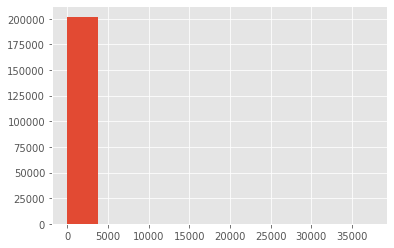

In [3]:
df.query('testgroup == "a"').revenue.hist()

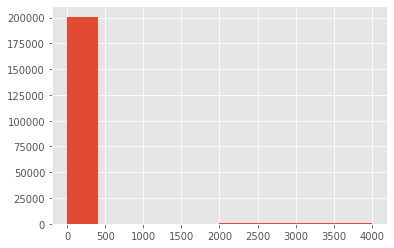

In [4]:
df.query('testgroup == "b"').revenue.hist()

[Text(0, 0.5, 'Revenue'), Text(0.5, 0, 'Group')]

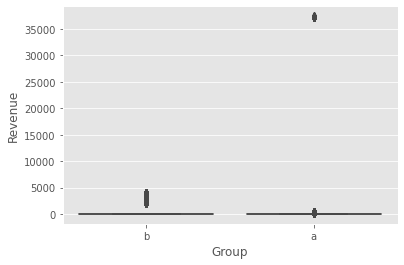

In [6]:
sns.boxplot(data=df, x='testgroup', y='revenue', ).set(xlabel='Group', ylabel='Revenue')

- По графикам можно предположить, что нормальным распределением выручки тут и не пахнет, однако проверим это с помощью теста Шапиро-Уилка на нормальность.

In [7]:
print(stats.shapiro(df.query('testgroup == "a"').revenue.sample(5000, random_state=17)))
print(stats.shapiro(df.query('testgroup == "b"').revenue.sample(5000, random_state=17)))

ShapiroResult(statistic=0.008855879306793213, pvalue=0.0)
ShapiroResult(statistic=0.07101619243621826, pvalue=0.0)


- Нулевая гипотеза о том, что выборка была взята из нормально распределенной генеральной совокупности отклоняется, так как p=value < 0.05
- Далее встает вопрос, какой тест будем использовать для оценки различий.
- Критерий Манна - Уитни не будет лучшим выбором, так как мы не знаем природу выбросов в одной из групп.
- На статистический вывод t-test сильно влияют выбросы, которые можно видеть на графиках в группе а, а значит этот тест тоже не подходит.
- Прибегаем к Bootstrap

In [10]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

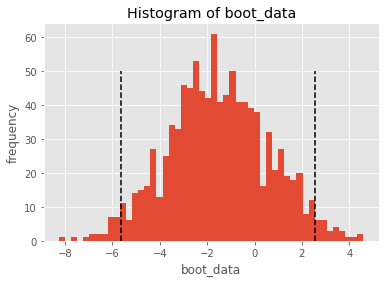

In [11]:
booted_data = get_bootstrap(df[df['testgroup'] == 'a']['revenue'], \
                            df[df['testgroup'] == 'b']['revenue'], boot_it = 3000) \
# в результате хранится разница двух распределений, ДИ и pvalue

In [12]:
booted_data['p_value']

0.46924036723046814

- Получаем pvalue > 0.05, а значит не можем отклонить 0 гипотезу, то есть с большей долей вероятности различия в значениях ARPU случайны

- Теперь проверим метрику ARPPU, то есть среднюю прибыль с платящих пользователей

In [5]:
ARPPU_b = df.query('testgroup == "b" and revenue > 0').revenue.mean()
ARPPU_a = df.query('testgroup == "a" and revenue > 0').revenue.mean()
(ARPPU_b - ARPPU_a) / ARPPU_a * 100

12.749997227996351

- В тестовой группе ARPPU больше на ~ 13%

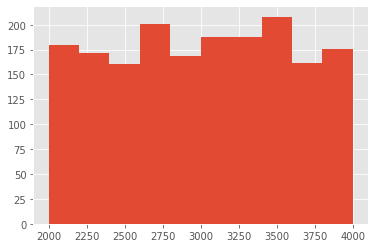

In [6]:
df.query('testgroup == "b" and revenue > 0').revenue.hist()

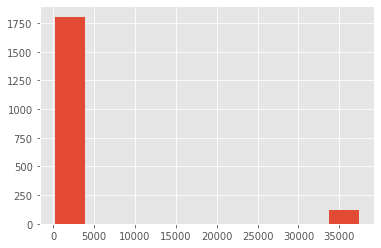

In [7]:
df.query('testgroup == "a" and revenue > 0').revenue.hist()

[Text(0, 0.5, 'Revenue'), Text(0.5, 0, 'Group')]

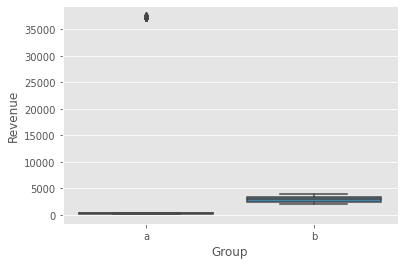

In [7]:
sns.boxplot(data= df.query('revenue > 0'), x='testgroup', y='revenue', ).set(xlabel='Group', ylabel='Revenue')

In [9]:
print(stats.shapiro(df.query('testgroup == "a" and revenue > 0').revenue.sample(1000, random_state=17)))
print(stats.shapiro(df.query('testgroup == "b" and revenue > 0').revenue.sample(1000, random_state=17)))

ShapiroResult(statistic=0.26476240158081055, pvalue=0.0)
ShapiroResult(statistic=0.9613320827484131, pvalue=1.2885095898576755e-15)


- Нулевая гипотеза о том, что выборка была взята из нормально распределенной генеральной совокупности отклоняется, так как p=value < 0.05
- Далее встает вопрос, какой тест будем использовать для оценки различий.
- Критерий Манна - Уитни не будет лучшим выбором, так как мы не знаем природу выбросов в одной из групп.
- На статистический вывод t-test сильно влияют выбросы, которые можно видеть на графиках в группе а, а значит этот тест тоже не подходит.
- Прибегаем к Bootstrap

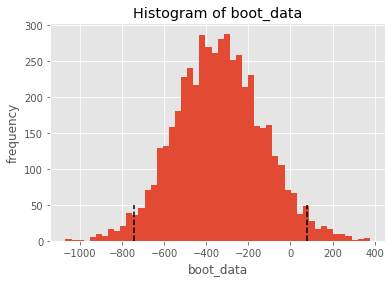

In [6]:
booted_data = get_bootstrap(df.query('testgroup == "a" and revenue > 0').revenue, \
                            df.query('testgroup == "b" and revenue > 0').revenue, boot_it = 3000)\
# в результате хранится разница двух распределений, ДИ и pvalue

In [7]:
booted_data['p_value']

0.10262138885713325

- Получаем pvalue > 0.05, а значит не можем отклонить 0 гипотезу, то есть с большей долей вероятности различия в значениях ARPPU тоже случайны
- Теперь проверяем конверсию

In [8]:
conversion_a = len(df.query('testgroup == "a" and revenue > 0').revenue) / len(df.query('testgroup == "a"').revenue) * 100
conversion_b = len(df.query('testgroup == "b" and revenue > 0').revenue) / len(df.query('testgroup == "b"').revenue) * 100
(conversion_a - conversion_b) / conversion_a  * 100

6.6402031503264904

- Конверсия в оплату оказалась больше в контрольной группе на ~ 7%
- Проверим не является ли эта разница случайной с помощью теста для категориальных переменных 

In [4]:
df['paying_user'] = df.revenue > 0

In [5]:
stats.chi2_contingency(pd.crosstab(df.paying_user, df.testgroup))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

- Получаем pvalue < 0.05, а значит можем принять альтернативную гипотезу:
    - показатель конверсии в контрольной группе значимо отличается от показателя в тестовой

## Вывод: 
- Исходя из результатов этого теста, нельзя сказать, что новый набор предложений положительно повлиял на показатели нашего продукта, а значит нет оснований  выкатывать фичу. Стоит разобраться с имеющимися выбросами в данных одной из групп и повторить тест.